# <span style="color:cyan">TP3 - RECONSTRUCTION DU SIGNAL AUDIO : TFCT inverse</span>

## <span style="color:cyan"><u>PRÉPARATION</u></span>

#### Soit $(x[n])$, $n\in\mathbb{Z}$ un signal audio (réel) discret et xmat sa matrice de TFCT, de dimensions $M\times L$ définies au TP2. xmat est calculée à partir des paramètres $N_{win}$, $N_{hop}$ et $N_{fft}$ également définis au TP2.
#### <u>1. $N_{win}$ est typiquement choisi pair pour le calcul de xmat. Quelle en est la raison ?

Pour avoir Nfft pair et donc X[Nfft/2] = conj(X[Nfft/2]) (Symetrie hermitienne).

#### <u>2. $N_{win}$ est typiquement choisi égal à $N_{fft}$ pour le calcul de xmat. Pourquoi ne pas choisir $N_{fft} < N_{win}$? Pourquoi ne pas choisir $N_{fft} > N_{win}$?

In [69]:
# Si on choisi Nfft different de Nwin on a des tailles differentes, on n'aura pas de trame de longueur Nhop en temporelle

#### On suppose dans la suite du TP que $N_{fft} = N_{win}$ et que ce paramètre est pair; et la $l^{ème}$ colonne de xmat, $l \in [0..L − 1]$, est notée $[X_l[0], X_l[1], .., X_l[M-1]]$
#### <u>3. Montrer que la TFD correspondant à la $l^{ème}$ trame fenêtrée de $x[n]$ s’écrit : 
#### $X_l[0], X_l[1], .., X_l[M − 1], X_l^*[M − 2], .., X_l^*[1]$, où $X_l^*[k]$ désigne le conjugué de $X_l[k]$.

In [70]:
# Symetrie hermitienne de la TFD

#### <u>4. Donner l’expression de la $l^{ème}$ trame du signal temporel, notée $(x_l[n]), n\in[0..N_{win}−1]$, en fonction de la lème colonne de xmat, $[X_l[0]..X_l[M − 1]]^T$ .

In [71]:
#Xl[n] = xl[n] * W[n]

#### <u>5. A quelle(s) condition(s) sur la $l^{ème}$ colonne de xmat, $[X_l[0]..X_l[M−1]]^T$ , cette trame est-elle réelle ?

In [72]:
# A condition que la symetrie hermitienne soit respecter

## <span style="color:cyan"><u>EN SÉANCE : Implémentation de la TFCT inverse par Overlap-Add (OLA)</u></span>

#### Cette séance consiste à implémenter l’algorithme de Transformée de Fourier à Court-Terme Inverse (ITFCT). La fonction, que l’on nommera itfct.py, aura pour paramètres d’entrée la matrice de TFCT d’un signal, le pas d’avancement de la fenêtre d’analyse Nhop, ainsi que le nombre de points fréquentiels utilisés dans l’algorithme TFCT $N_{fft}$ et la fréquence d’échantillonnage $F_s$ du signal initial.
#### La matrice de TFCT, notée xmat, de dimensions $M \times L$ doit être obtenue à partir de l’algorithme tfct.py codé au TP2. Dans le cas où cet algorithme n’est pas fonctionnel, vous utiliserez la matrice de TFCT xmat.npy fournie sur Moodle, avec le matériel de TP3, et vous la chargerez avec l’instruction np.load(’xmat.npy’). Les étapes de l’algorithme OLA sont résumées ci-dessous, et décrites dans la figure ci-dessous.

<img src="figureOLA.png" height="500" style="display:block; margin-left:auto; margin-right:auto;">

##### <div align="center"> <em>Principe de l’algorithme OLA de la transformée de Fourier à court-terme inverse (ITFCT) pour la synthèse d’un signal sonore. </em></div>


##### <u>**Etape 1**</u> : reconstruire la TFD de chaque trame à partir des colonnes de la matrice xmat de TFCT, dans des vecteurs de taille $N_{fft}$.
##### <u>**Etape 2**</u> : reconstruire chaque trame fenêtrée en effectuant la TFD inverse (ITFD) des vecteurs de TFD : ⇒ $L$ trames fenêtrées $y_l, l \in [0, L − 1]$ :
#####    $y_1[n] = x[n]w[n]$
#####    $y_2[n] = x[n + N_{hop}]w[n]$
#####    ..
#####    $y_L[n] = x[n + (L − 1)N_{hop}]w[n]$
##### La TFD inverse reconstruit des trames de longueur $N_{fft}$. Cette longueur est supposée égale à la longueur des trames découpées lors de l’algorithme TFCT (c’est le cas si la TFD a été effectuée sur un nombre correct de points).
#### <u>**Etape 3**</u> : décaler la lè trame $y_l$, de $(l − 1)$ trames ⇒ synchronisation des $y_l, l \in [1, L]$ :
#####   $y_1[n] ⇒ y_1[n] = x[n]w[n]$
#####   $y_2[n] ⇒ y_2[n − N_{hop}] = x[n]w[n − N_{hop}]$
#####    ..
#####   $y_L[n] ⇒y_L[n − (L − 1)N_{hop}] = x[n]w[n − (L − 1)N_{hop}]$
##### <u>**Etape 4**</u> : sommer les trames décalées $y_l[n − (l − 1)N_{hop}]$
##### $$\sum_{l=1}^{L} y_l[n − (l − 1)N_{hop}] = x[n] \sum_{l=1}^{L} w[n − (l − 1)N_{hop}]$$
##### <u>**Etape 5**</u> : normaliser le signal temporel. Les fenêtres usuelles sont choisies de sorte que la somme $K = \sum_{l=1}^{L} w[n − (l − 1)N_{hop}]$ soit indépendante de $n$. Dans ce cas (cf. Cours4bis): $K \approx \sum_{l=1}^{L} w[n]/N_{hop}$ (égalité lorsque $N_{win}$ est un multiple de $N_{hop}$). Alors
##### $$\frac{1}{K}\sum_{l=1}^{L} y_l[n − (l − 1)N_{hop}] ≈ x[n]$$

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import sounddevice as sd
import soundfile as sf

#### Les paramètres de sortie de la fonction itfct.py seront le signal temporel reconstruit, noté $y_{vect}$ et le vecteur temporel utile à son affichage. Cette séance vise à réimplémenter les différentes étapes l’algorithme.
#### 1. Préallocation de mémoire pour le signal reconstruit $y$ : <u>déterminer sa taille en fonction des paramètres d’entrée, puis déclarer le vecteur $y$ initialement rempli de 0.</u>

In [74]:
Fs,xvect = wav.read('sound.wav')

xmat = np.load("xmat.npy")
M, L = xmat.shape
Nwin=1024
Nhop=512
Nfft=1024
w = np.hamming(Nwin)

y = np.zeros((L - 1) * Nhop + Nwin)

#### <u> 2. et 3. Reconstruction de chaque trame $y_l$ à partir de sa TFD (colonne de xmat) puis somme des trames reconstruites $y_l$ à la bonne position de $y$

In [75]:
for l in range(L):
    X_half = xmat[:, l]
    X = np.zeros(Nfft, dtype=complex)
    X[:M] = X_half
    X[M:] = np.conj(X_half[-2:0:-1])

    trame = np.real(np.fft.ifft(X)) / w

    y[l * Nhop : l * Nhop + Nwin] += trame

print("xmat", xmat.shape)
print("X", X.shape)

xmat (513, 336)
X (1024,)


#### <u> 4. Normalisation de $y$ : division par $\sum^{N_{win}-1}_{n=0} w[n]/N_{hop}$.</u> La fenêtre, correspondant à celle utilisée lors de l’algorithme tftct, est supposée être une fenêtre de Hamming de longueur $N_{fft}$.

In [76]:
for l in range(L):
    K = np.sum(w) / Nhop
    y /= K

#### 5. Test de l’algorithme sur la matrice xmat calculée par l’algorithme tfct.py, appliqué au fichier audio sound.wav. <u>Préciser et discuter la valeur des paramètres utilisés pour la TFCT. Afin de comparer le résultat au fichier initial, calculer l’erreur quadratique entre ces deux signaux. Commenter.</u>

Les paramètres utilisés pour la TFCT permettent de n'avoir aucune pertes lors de la reconstruction du signal initial pendant la ITFCT.

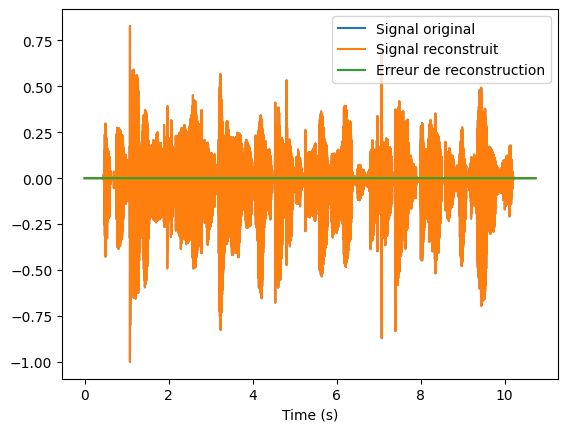

Erreur quadratique moyenne (EQM) : 5.1998903845051034e-33


In [ ]:
def ITFCT(xmat, Nwin=1024, Nhop=512, Nfft=1024):
    M, L = xmat.shape
    w = np.hamming(Nwin)
    y = np.zeros((L - 1) * Nhop + Nwin)

    for l in range(L):
        X_half = xmat[:, l]
        X_full = np.zeros(Nfft, dtype=complex)
        X_full[:M] = X_half
        X_full[M:] = np.conj(X_half[-2:0:-1])

        trame = np.real(np.fft.ifft(X_full)) / w

        y[l * Nhop : l * Nhop + Nwin] += trame

    K = np.sum(w) / Nhop
    y /= K
    return y


x_rec = ITFCT(xmat, Nwin, Nhop, Nfft)
x_rec = x_rec[: len(xvect)]
t = np.arange(len(x_rec)) / Fs

xvect = xvect / np.max(np.abs(xvect))
x_rec = x_rec / np.max(np.abs(x_rec))

plt.figure()
# debut = 8000
# fin = 12000
# plt.plot(t[debut:fin],xvect[debut:fin], label="Signal original")
# plt.plot(t[debut:fin], x_rec[debut:fin], label="Signal reconstruit")
plt.plot(t, xvect, label="Signal original")
plt.plot(t, x_rec, label="Signal reconstruit")
plt.plot(t, xvect - x_rec, label="Erreur de reconstruction")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

mse = np.mean((xvect - x_rec) ** 2)
print("Erreur quadratique moyenne (EQM) :", mse)